<a href="https://colab.research.google.com/github/EllouziMedAmin/DSWithPytorch/blob/main/multi_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chromadb
!pip install open-clip-torch


In [7]:
import os
import numpy as np
from matplotlib import pyplot as plt

import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
import open_clip

In [8]:
# source: https://pypi.org/project/open-clip-torch-any-py3/
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [30]:
chroma_db = chromadb.Client()

In [31]:
img_loader = ImageLoader()
multimodal_embedding_fn = OpenCLIPEmbeddingFunction()
chroma_collection = chroma_db.get_or_create_collection("dogs", embedding_function=multimodal_embedding_fn, data_loader=img_loader)

In [41]:
img_folder = "data/dogs"
img_files = os.listdir(img_folder)

In [42]:
img_files

['akita_3.jpg',
 'affenpinscher_3.jpg',
 'mastiff_1.jpg',
 'entlebucher_001.jpg',
 'corgi_13.jpg',
 'akita_1.jpg']

In [43]:
img_files = [f"{img_folder}/{img_file}" for img_file in img_files]

In [44]:
img_files

['data/dogs/akita_3.jpg',
 'data/dogs/affenpinscher_3.jpg',
 'data/dogs/mastiff_1.jpg',
 'data/dogs/entlebucher_001.jpg',
 'data/dogs/corgi_13.jpg',
 'data/dogs/akita_1.jpg']

In [45]:
img_ids = [os.path.basename(f) for f in img_files]
img_ids

['akita_3.jpg',
 'affenpinscher_3.jpg',
 'mastiff_1.jpg',
 'entlebucher_001.jpg',
 'corgi_13.jpg',
 'akita_1.jpg']

In [46]:
chroma_collection.add(
    ids=img_ids,  # Ensure unique IDs
    uris=img_files  # Store file paths
)


In [47]:
all_docs = chroma_collection.get(include=['uris'])
print(all_docs)

{'ids': ['akita_3.jpg', 'affenpinscher_3.jpg', 'mastiff_1.jpg', 'entlebucher_001.jpg', 'corgi_13.jpg', 'akita_1.jpg'], 'embeddings': None, 'documents': None, 'uris': ['data/dogs/akita_3.jpg', 'data/dogs/affenpinscher_3.jpg', 'data/dogs/mastiff_1.jpg', 'data/dogs/entlebucher_001.jpg', 'data/dogs/corgi_13.jpg', 'data/dogs/akita_1.jpg'], 'data': None, 'metadatas': None, 'included': [<IncludeEnum.uris: 'uris'>]}


In [48]:
data_check = chroma_collection.get(include=['uris'])
print("After adding images:", data_check)

After adding images: {'ids': ['akita_3.jpg', 'affenpinscher_3.jpg', 'mastiff_1.jpg', 'entlebucher_001.jpg', 'corgi_13.jpg', 'akita_1.jpg'], 'embeddings': None, 'documents': None, 'uris': ['data/dogs/akita_3.jpg', 'data/dogs/affenpinscher_3.jpg', 'data/dogs/mastiff_1.jpg', 'data/dogs/entlebucher_001.jpg', 'data/dogs/corgi_13.jpg', 'data/dogs/akita_1.jpg'], 'data': None, 'metadatas': None, 'included': [<IncludeEnum.uris: 'uris'>]}


In [49]:
def show_query_results(query_list, query_result):
    """Displays the retrieved images and their distances from the query."""
    res_count = len(query_result['ids'][0])
    for i, query in enumerate(query_list):
        print(f"Query: {query}")
        for j in range(res_count):
            uri = query_result['uris'][i][j]
            distance = query_result['distances'][i][j]
            print(f"Result {j + 1}: {uri} (Distance: {np.round(distance, 2)})")
            img = plt.imread(uri)
            plt.imshow(img)
            plt.axis("off")
            plt.show()

Query: dog in grassland
Result 1: data/dogs/entlebucher_001.jpg (Distance: 1.47)


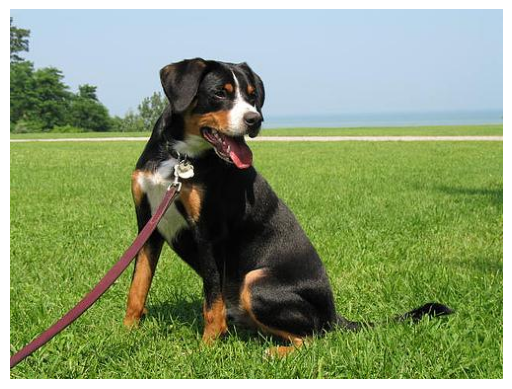

Result 2: data/dogs/mastiff_1.jpg (Distance: 1.56)


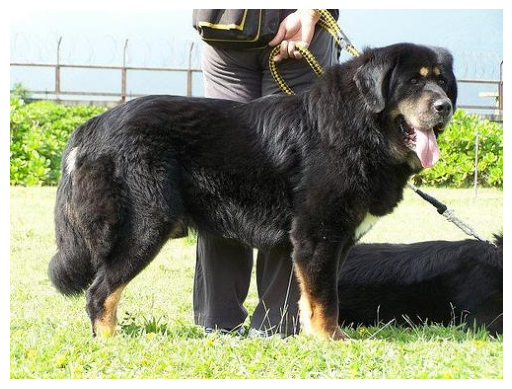

In [51]:
txt_query_list = ["dog in grassland"]
query_result = chroma_collection.query(
    query_texts=txt_query_list,
    n_results=2,
    include=['uris', 'distances']
)
show_query_results(txt_query_list, query_result)

In [54]:
from PIL import Image

# Function to load an image and convert to a NumPy array
def load_image_as_numpy(image_path):
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure it's RGB
        img_array = np.array(img)  # Convert to NumPy array
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None


In [55]:
# Load image before querying
query_img_path = "data/dogs/akita_1.jpg"
query_img = load_image_as_numpy(query_img_path)

In [56]:
# Ensure image is loaded correctly
if query_img is not None:
    query_result = chroma_collection.query(
        query_images=[query_img],  # Pass the NumPy array, not the file path
        n_results=2,
        include=['uris', 'distances']
    )
    print("Query Results:", query_result)
else:
  print("Error: Query image could not be loaded.")


Query Results: {'ids': [['akita_1.jpg', 'akita_3.jpg']], 'embeddings': None, 'documents': None, 'uris': [['data/dogs/akita_1.jpg', 'data/dogs/akita_3.jpg']], 'data': None, 'metadatas': None, 'distances': [[0.0, 0.43969565629959106]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.uris: 'uris'>]}


Query: data/dogs/akita_1.jpg
Result 1: data/dogs/akita_1.jpg (Distance: 0.0)


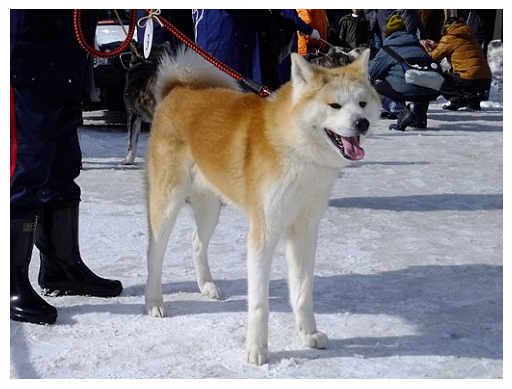

Result 2: data/dogs/akita_3.jpg (Distance: 0.44)


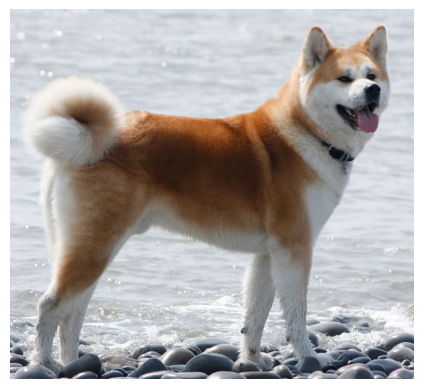

In [57]:
show_query_results([query_img_path], query_result)